In [1]:
#run in case required libaraies are not installed
!pip install torch
!pip install pykan
!pip install numpy
!pip install imageio

In [2]:
from kan import KAN, LBFGS
import torch
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm
from torch.autograd import grad
import numpy as np
import time
#assign given constants from the problem
L = 1.2 #Henries
C = 0.3 #Farads
V0 = 12 #Volts


#list of timesteps t to train PINN model
x_train = torch.tensor([np.linspace(0, 6, 20)], dtype = torch.float32).reshape(-1,1)
x_train = torch.load('/Users/kngtjn/ML4MD/group_project/data/x_train.pt')
x_train.requires_grad = True

model = KAN(width=[1,2,1], grid=5, k=7, grid_eps=1.0, noise_scale_base=0.25,)
model.update_grid_from_samples(x_train)
#test datasets to test PINN model
x_test = torch.load('/Users/kngtjn/ML4MD/group_project/data/x_test.pt')
x_test.requires_grad = True
y_test_R15 = torch.load('/Users/kngtjn/ML4MD/group_project/data/y_test_R=1.5.pt')
y_test_R40 = torch.load('/Users/kngtjn/ML4MD/group_project/data/y_test_R=4.pt')
y_test_R60 = torch.load('/Users/kngtjn/ML4MD/group_project/data/y_test_R=6.pt')

# define solution

steps = 50

train_loss = list()
ode_loss = list()
IC1_loss = list()
IC2_loss = list()

def train(resistance = 1.5):
    optimizer = LBFGS(model.parameters(), lr=0.05, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
    pbar = tqdm(range(steps), desc='description')
    loss_function = torch.nn.MSELoss()
    for _ in pbar:
        def closure():
            global loss_1, loss_2, loss_3
            optimizer.zero_grad()
            # interior loss
            y_pred_train = model(x_train)
            #========<< INDUCTIVE BIAS WITHIN LOSS FUNCTION >>========
            # 1. Calculation of 1st/2nd order derivatives
            dy_dt = grad(outputs = y_pred_train,
                         inputs = x_train,
                         grad_outputs = torch.ones_like(y_pred_train),
                         create_graph =  True)[0]
            
            dy_dt2 =grad(outputs = dy_dt,
                         inputs = x_train,
                         grad_outputs = torch.ones_like(dy_dt),
                         create_graph =  True)[0]

            # 2. 2nd order ODE and Initial conditions
            ode = torch.tensor(np.zeros(len(x_train)), dtype = torch.float32)  # 2nd order ODE
            IC1 = torch.tensor([0.])   # Initial condition 1
            IC2 = torch.tensor([V0/L]) # Initial condition 2
            R = torch.tensor([resistance])
            ode_result = dy_dt2 + (R/L) * dy_dt + (1/(L*C)) * y_pred_train
            
            y_t0 = torch.tensor([y_pred_train[0]]) # y(t) at t = 0
            dy_dt_t0 = torch.tensor([dy_dt[0]]) # dydt at t = 0 
        
            loss_1 = loss_function(ode, ode_result)
            loss_2 = loss_function(IC1, y_pred_train[0])
            loss_3 = loss_function(IC2, dy_dt[0])
            loss = loss_1 + loss_2 + loss_3
            
            loss.backward()
            return loss
        

        optimizer.step(closure)
        loss = loss_1 + loss_2 + loss_3
        if loss < 0.01:
                break
        train_loss.append(loss.detach().numpy())
        ode_loss.append(loss_1.detach().numpy())
        IC1_loss.append(loss_2.detach().numpy())
        IC2_loss.append(loss_3.detach().numpy())

train()


/var/folders/cn/d10dnmx96hbc42y3fr8bqt9c0000gn/T/ipykernel_36719/4000129284.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  x_train = torch.tensor([np.linspace(0, 6, 20)], dtype = torch.float32).reshape(-1,1)
description:   0%|          | 0/50 [00:00<?, ?it/s]/opt/homebrew/anaconda3/envs/pykan-env/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
description:  12%|█▏        | 6/50 [00:01<00:08,  4.95it/s]


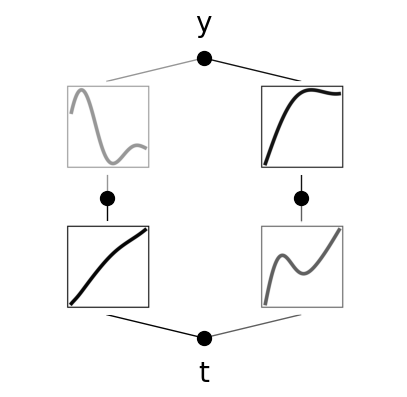

In [6]:
model.plot(in_vars = ['t'], out_vars = ['y'])
plt.savefig('KAN_RLC_fixed.png', transparent = True)

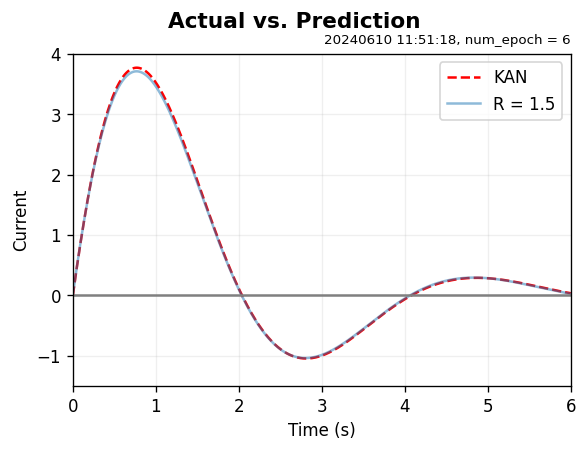

In [4]:
plt.figure(figsize = (5,4), dpi = 120)
#plt.text(0.1, 3.8, 'number of train data point: %s' %n, size=7, color='red')
#plt.text(0.1, -1.3, 'act_function: %s' %str(act_fun), size=7, color='blue')
date = time.strftime('%Y%m%d %H:%M:%S')
plt.plot(x_test.detach().numpy(), model(x_test).detach().numpy(), label = 'KAN', ls = '--', color = [1, 0, 0])
plt.plot(x_test.detach().numpy(), y_test_R15.detach().numpy(), label = 'R = 1.5', alpha = 0.5)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Current')
plt.axhline(y = 0, color = [0.5, 0.5, 0.5])
plt.xlim(0, 6)
plt.ylim(-1.5, 4)
plt.suptitle('Actual vs. Prediction', weight = 'bold', fontsize = 13, y = 0.93)
plt.title('%s, num_epoch = 6'%(date, ), fontsize  = 8, loc = 'right')
plt.grid(alpha = 0.2)
plt.tight_layout()

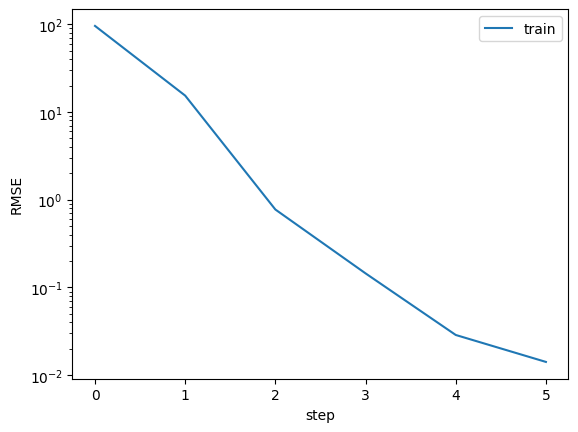

In [5]:
plt.plot(train_loss)
plt.legend(['train'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

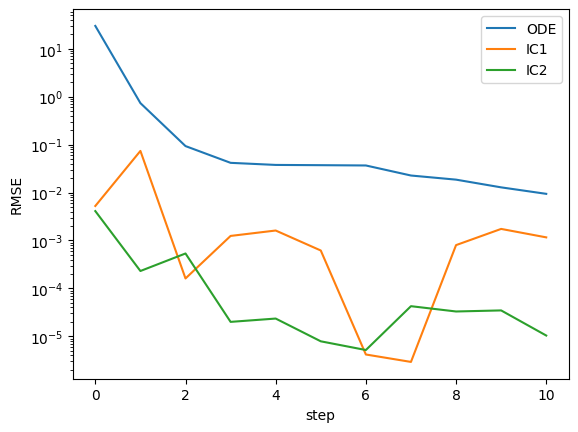

In [121]:
plt.plot(ode_loss)
plt.plot(IC1_loss)
plt.plot(IC2_loss)
plt.legend(['ODE', 'IC1', 'IC2'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')